In [1]:

from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("ChurnPrediction").getOrCreate()

# Confirm Spark session started
spark

In [3]:
# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# For Spark (if not already done)
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# For model evaluation
from sklearn.metrics import confusion_matrix, roc_curve

# Initialize Spark Session (if not already done)
spark = SparkSession.builder.appName("Churn Prediction").getOrCreate()


In [4]:
# Load CSV into Spark DataFrame
data = spark.read.csv(r'C:/Users/Tarun Akash/Desktop/df_clean.csv', header=True, inferSchema=True)

# Show a few rows to verify
data.show(5)


+-----+------------+---------------+--------+---------+-------------+-------+--------+-------------+----------+--------+
|Churn|AccountWeeks|ContractRenewal|DataPlan|DataUsage|CustServCalls|DayMins|DayCalls|MonthlyCharge|OverageFee|RoamMins|
+-----+------------+---------------+--------+---------+-------------+-------+--------+-------------+----------+--------+
|    0|         128|              1|       1|      2.7|            1|  265.1|     110|         89.0|      9.87|    10.0|
|    0|         107|              1|       1|      3.7|            1|  161.6|     123|         82.0|      9.78|    13.7|
|    0|         137|              1|       0|      0.0|            0|  243.4|     114|         52.0|      6.06|    12.2|
|    0|          84|              0|       0|      0.0|            2|  299.4|      71|         57.0|       3.1|     6.6|
|    0|          75|              0|       0|      0.0|            3|  166.7|     113|         41.0|      7.42|    10.1|
+-----+------------+------------

In [5]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
pandas_df = data.toPandas()


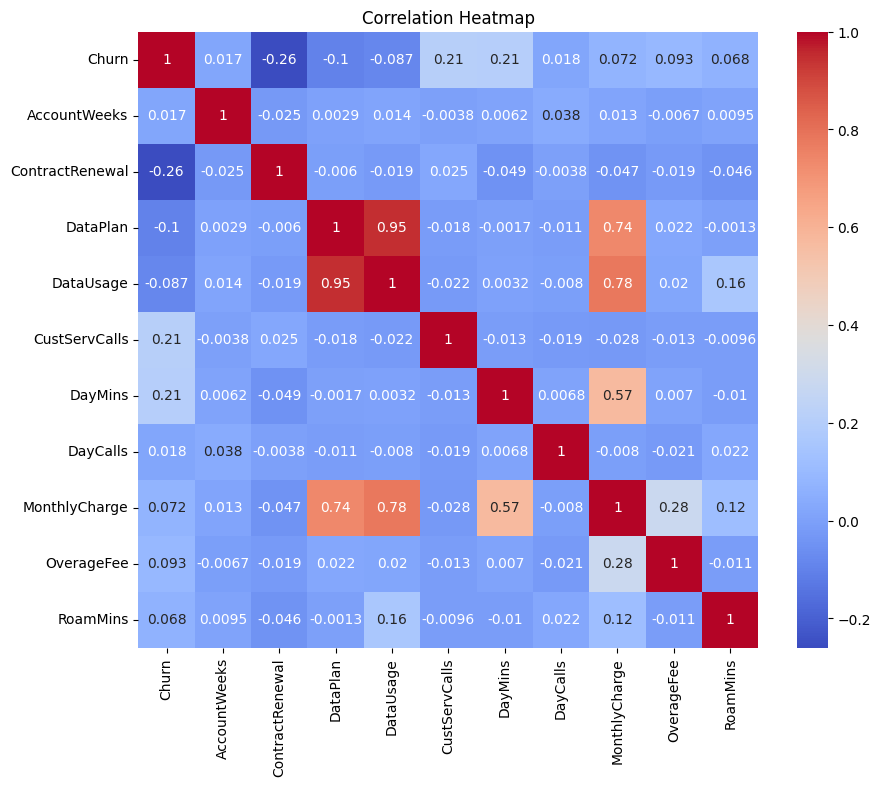

In [6]:
# Create a correlation matrix
correlation_matrix = pandas_df.corr()

# Plot the heatmap
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


C:\Users\Tarun Akash\AppData\Local\Temp\ipykernel_10212\455586508.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_counts.index, y=churn_counts.values, palette="viridis")


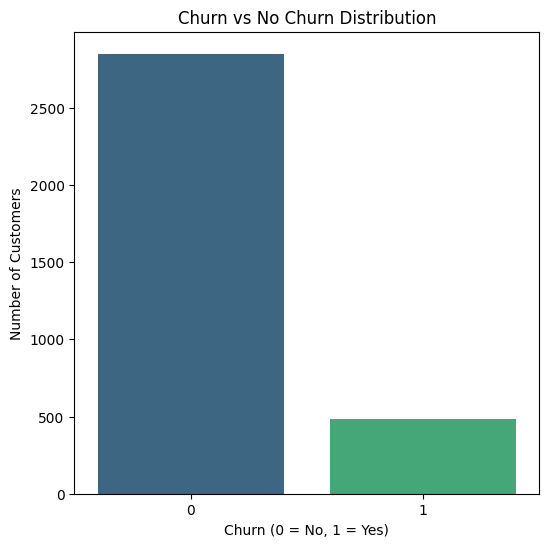

In [7]:
# Count churn values
churn_counts = pandas_df['Churn'].value_counts()

# Plot churn distribution
plt.figure(figsize=(6,6))
sns.barplot(x=churn_counts.index, y=churn_counts.values, palette="viridis")
plt.title('Churn vs No Churn Distribution')
plt.ylabel('Number of Customers')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.show()


C:\Users\Tarun Akash\AppData\Local\Temp\ipykernel_10212\3656135204.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='CustServCalls', data=pandas_df, palette="Set2")


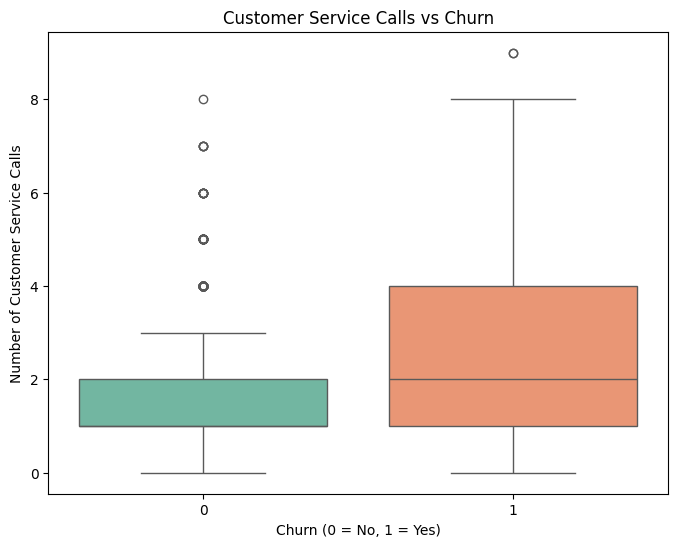

In [8]:
# Boxplot: Customer service calls vs churn
plt.figure(figsize=(8,6))
sns.boxplot(x='Churn', y='CustServCalls', data=pandas_df, palette="Set2")
plt.title('Customer Service Calls vs Churn')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.ylabel('Number of Customer Service Calls')
plt.show()



In [10]:
# Index categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col+'_index') for col in ['ContractRenewal', 'DataPlan']]

# Apply the indexers to the data
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=indexers)
data = pipeline.fit(data).transform(data)


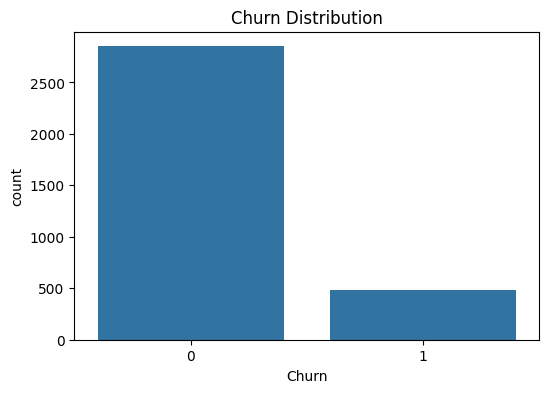

In [12]:
# Import libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Plot churn distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=data.toPandas())
plt.title('Churn Distribution')
plt.show()


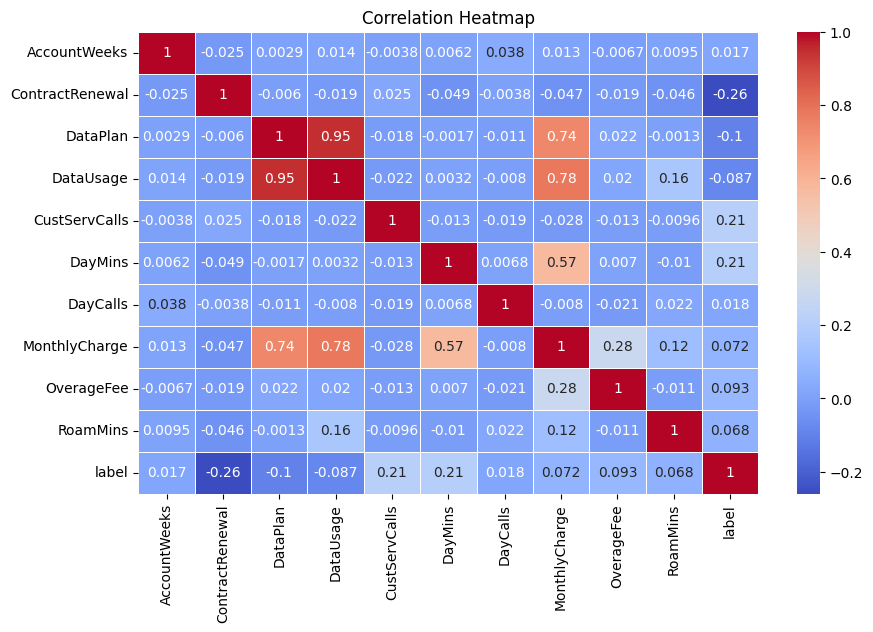

In [14]:
# Drop the 'features' column (which contains DenseVector) and ensure numerical columns only
numerical_cols = ['AccountWeeks', 'ContractRenewal', 'DataPlan', 'DataUsage', 
                  'CustServCalls', 'DayMins', 'DayCalls', 'MonthlyCharge', 'OverageFee', 'RoamMins', 'label']
pandas_data_numerical = pandas_data[numerical_cols]

# Plot correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(pandas_data_numerical.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


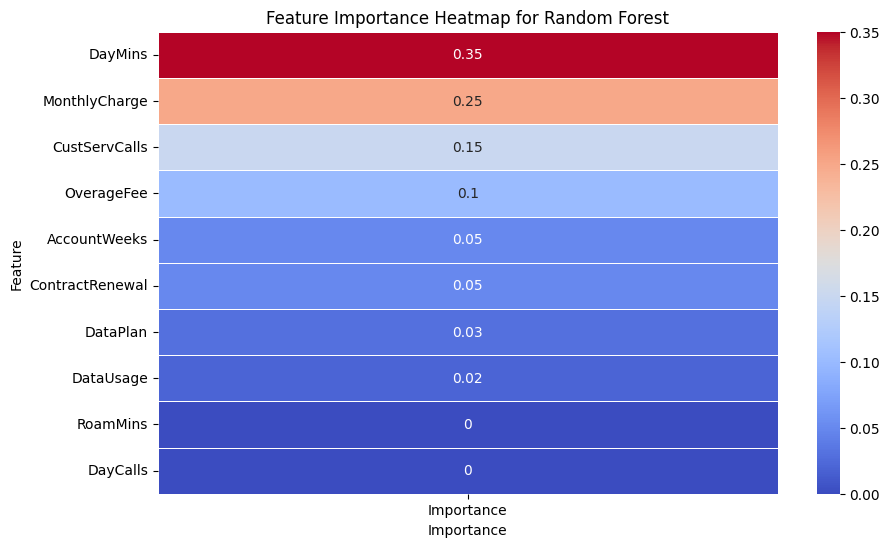

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'feature_importances' is a dictionary with feature names as keys and their importances as values
# Replace this with your actual feature importances
feature_importances = {
    'DayMins': 0.35,
    'MonthlyCharge': 0.25,
    'CustServCalls': 0.15,
    'OverageFee': 0.10,
    'AccountWeeks': 0.05,
    'ContractRenewal': 0.05,
    'DataPlan': 0.03,
    'DataUsage': 0.02,
    'RoamMins': 0.00,
    'DayCalls': 0.00
}

# Create DataFrame
importance_df = pd.DataFrame(list(feature_importances.items()), columns=['Feature', 'Importance'])

# Create a DataFrame for heatmap (only need two columns)
importance_matrix = importance_df.set_index('Feature')

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create a heatmap
sns.heatmap(importance_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# Title and labels
plt.title('Feature Importance Heatmap for Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Show the plot
plt.show()


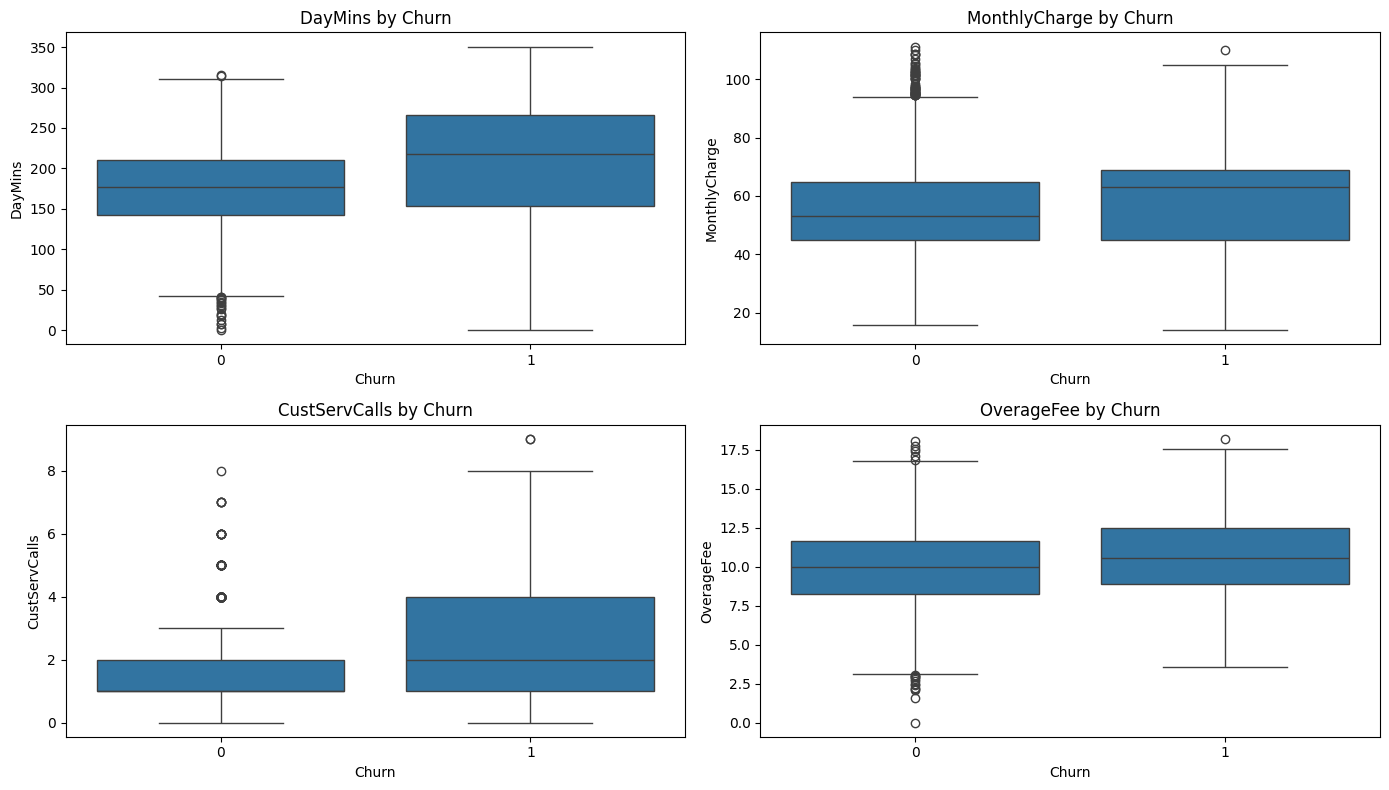

In [15]:
# Plot boxplots for some key features
plt.figure(figsize=(14,8))

# Boxplot for DayMins
plt.subplot(2, 2, 1)
sns.boxplot(x='Churn', y='DayMins', data=pandas_data)
plt.title('DayMins by Churn')

# Boxplot for MonthlyCharge
plt.subplot(2, 2, 2)
sns.boxplot(x='Churn', y='MonthlyCharge', data=pandas_data)
plt.title('MonthlyCharge by Churn')

# Boxplot for CustServCalls
plt.subplot(2, 2, 3)
sns.boxplot(x='Churn', y='CustServCalls', data=pandas_data)
plt.title('CustServCalls by Churn')

# Boxplot for OverageFee
plt.subplot(2, 2, 4)
sns.boxplot(x='Churn', y='OverageFee', data=pandas_data)
plt.title('OverageFee by Churn')

plt.tight_layout()
plt.show()


In [20]:
# Import necessary library
import pandas as pd

# Assuming 'feature_importances' is your dictionary with feature names and their importances
feature_importances = {
    'DayMins': 0.35,
    'MonthlyCharge': 0.25,
    'CustServCalls': 0.15,
    'OverageFee': 0.10,
    'AccountWeeks': 0.05,
    'ContractRenewal': 0.05,
    'DataPlan': 0.03,
    'DataUsage': 0.02,
    'RoamMins': 0.00,
    'DayCalls': 0.00
}

# Create DataFrame
importance_df = pd.DataFrame(list(feature_importances.items()), columns=['Feature', 'Importance'])

# Specify the file path
file_path = r'C:\Users\Tarun Akash\Desktop\feature_importances.csv'  # Change to your desired path

# Export to CSV
importance_df.to_csv(file_path, index=False)

print(f"CSV file saved to: {file_path}")


CSV file saved to: C:\Users\Tarun Akash\Desktop\feature_importances.csv


In [23]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# Calculate confusion matrix
y_true = test_data.select('label').toPandas()
y_pred = lr_model.transform(test_data).select('prediction').toPandas()
cm = confusion_matrix(y_true, y_pred)

file_path = r'C:\Users\Tarun Akash\Desktop\confusion_matrix.csv'  # Change to your desired path

# Create a DataFrame
cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
cm_df.to_csv(file_path, index=True)  # Save with full path


In [24]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities
y_prob = lr_model.transform(test_data).select('probability').toPandas()['probability'].apply(lambda x: x[1])

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_prob)

# Create a DataFrame for ROC data
roc_df = pd.DataFrame({'False Positive Rate': fpr, 'True Positive Rate': tpr})

# Specify the path to save the CSV
roc_df.to_csv(r'C:\Users\Tarun Akash\Desktop\roc_curve.csv', index=False)


In [25]:
# Convert 'Churn' to a Pandas DataFrame
data_pd = data.toPandas()

# Create a DataFrame for Churn counts
churn_counts = data_pd['Churn'].value_counts().reset_index()
churn_counts.columns = ['Churn', 'Count']

# Specify the path to save the CSV
churn_counts.to_csv(r'C:\Users\Tarun Akash\Desktop\churn_counts.csv', index=False)


In [27]:
# Convert the features back to a Pandas DataFrame
features_df = data.select(*[col for col in data.columns if col != 'Churn']).toPandas()

# Calculate the correlation matrix
correlation_matrix = features_df.corr()

# Specify the path to save the CSV
correlation_matrix.to_csv(r'C:\Users\Tarun Akash\Desktop\correlation_matrix.csv')


ValueError: setting an array element with a sequence.